In [2]:
import time
import glob
import folium
import numpy as np
import pandas as pd
from random import *
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
bus_id_list = [
    9000609, 9000247, 9000562, 9000597, 9000219, 9000246, 9000666, 9000645, 9000657, 9000630
]

type_code_list = [1,3,5,6,7,22,23,24]

In [4]:
df_dict = {}

for bus_id in bus_id_list:
    df = pd.read_csv(f"data/vehicle.parsedmqtts_{bus_id}.csv")

    # 전처리
    # df = preprocess_df(df)

    df_dict[bus_id] = df

In [ ]:
# single df
id = bus_id_list[3]
df = pd.read_csv(f"data/vehicle.parsedmqtts_{id}.csv")

# 전처리
# df = preprocess_df(df)

In [5]:
total_df = pd.concat(df_dict.values(), ignore_index=True)

In [ ]:
total_df.shape

In [ ]:
total_df['createdAt'] = pd.to_datetime(total_df['createdAt'])
total_df['created_dt'] = total_df['createdAt'].dt.strftime('%Y%m%d')

In [ ]:
total_df['created_dt'].min(), total_df['created_dt'].max()

In [ ]:
monthly_counts = total_df['createdAt'].dt.to_period('M').value_counts().sort_index()

print(monthly_counts)

In [6]:
non_nan_columns = df.columns[~df.isna().any()]

In [7]:
non_nan_columns

Index(['_id', 'Topic', 'TypeName', 'serialnumber', 'uniqTime', 'Type',
       'SubType', 'TimeStamp', 'Length', 'createdAt', 'updatedAt'],
      dtype='object')

In [ ]:
target_columns = [
    'serialnumber', 'Topic', 'Type', 'uniqTime', 'GpsStatus', 'BatteryV', 'createdAt', 'updatedAt', 'TripID', 'TotalDrvDistance', 'TotalDistance', 'Trip_run_time',
    'EventTime', 'VBAT', 'ResultCode'
]

In [ ]:
col_list = []

for col in df.columns:
    if '[' in col:
        if not col.endswith('[0]'):
            continue

    col_list.append(col)
    # print(col)

In [ ]:
missing_percentage = total_df[col_list].isnull().mean() * 100
r_df = missing_percentage.reset_index()
r_df.columns = ['Index', 'Value']

In [ ]:
r_df[r_df.Index == 'Speed[21]']

In [ ]:
total_df.CurLatitude.iloc[0]

In [ ]:
df.TripID.max()

In [ ]:
print(df[df.TripID == 2408140821000.0].shape[0])
print(df[df.TripID == 2408140821000.0].TripDataCnt.iloc[0])

In [ ]:
result_df = missing_percentage.reset_index()
result_df.columns = ['Index', 'Value']

result_df.shape[0]

## 변수 기분 분석

In [17]:
p_df = total_df.TripDataCnt.value_counts().to_frame().reset_index()
p_df.columns = ['TripDataCnt', 'Counts']

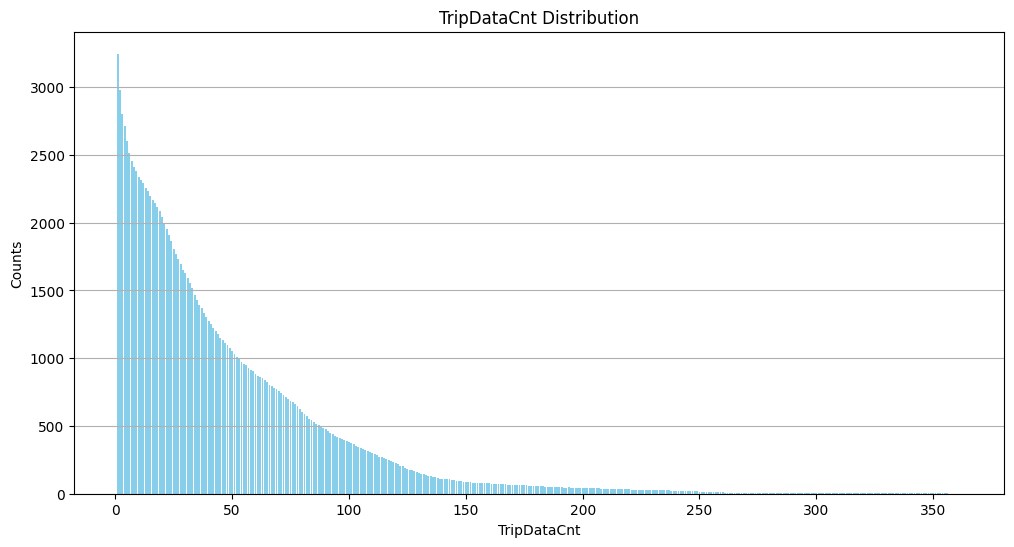

In [18]:
plt.figure(figsize=(12, 6))
plt.bar(p_df['TripDataCnt'], p_df['Counts'], color='skyblue')
plt.title('TripDataCnt Distribution')
plt.xlabel('TripDataCnt')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [22]:
total_df.TripDataCnt.max()

np.float64(362.0)

In [26]:
speed_columns = [f'Speed[{i}]' for i in range(60)]
speeds = total_df[speed_columns]

all_speeds = speeds.values.flatten()
all_speeds = all_speeds[(~np.isnan(all_speeds)) & (all_speeds > 0)]

average_speed = all_speeds.mean()

In [27]:
average_speed

np.float64(22.295667126876594)

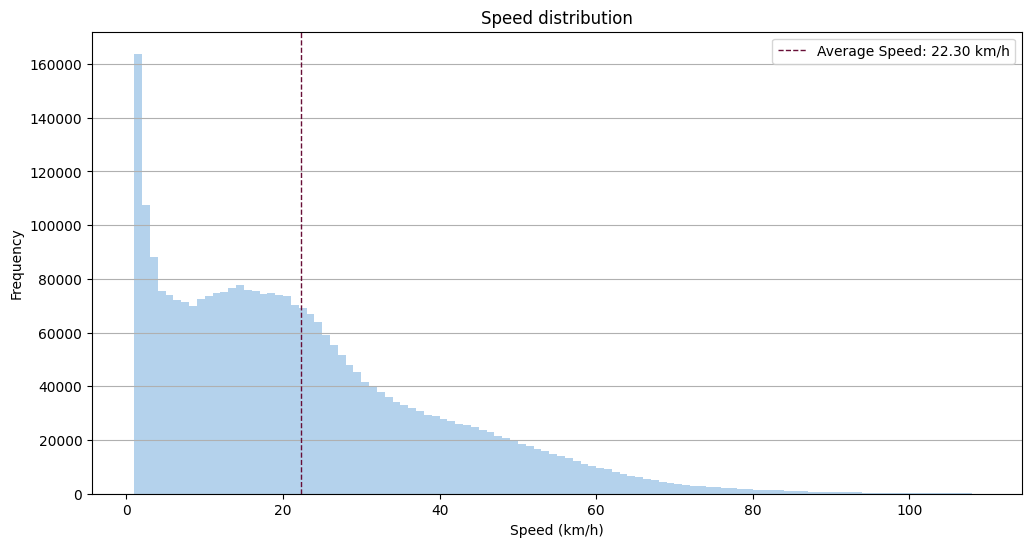

In [38]:
plt.figure(figsize=(12, 6))
plt.hist(all_speeds, bins=range(int(min(all_speeds)), int(max(all_speeds)) + 2, 1), color='#95bfe5', alpha=0.7)
plt.title('Speed distribution')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# 평균 속도 표시
plt.axvline(average_speed, color='#670e36', linestyle='dashed', linewidth=1, label=f'Average Speed: {average_speed:.2f} km/h')
plt.legend()
plt.show()

In [64]:
average_distance_per_trip = total_df.groupby('TripID')['TotalDrvDistance'].mean().reset_index()
average_distance_per_trip = average_distance_per_trip[(~np.isnan(average_distance_per_trip.TotalDrvDistance)) & (average_distance_per_trip.TotalDrvDistance > 0)]

In [47]:
average_distance_per_trip.shape

(3228, 2)

In [65]:
trip_data = [distance for distance in average_distance_per_trip['TotalDrvDistance']]

In [69]:
trip_data[:5]

[34929.0, 77832.0, 77832.0, 77832.0, 77832.05882352941]

In [70]:
average_distance_per_trip['TripID'].tolist()[:5]

[2102021009000.0,
 2405171110001.0,
 2405171124000.0,
 2405171140001.0,
 2405171149002.0]

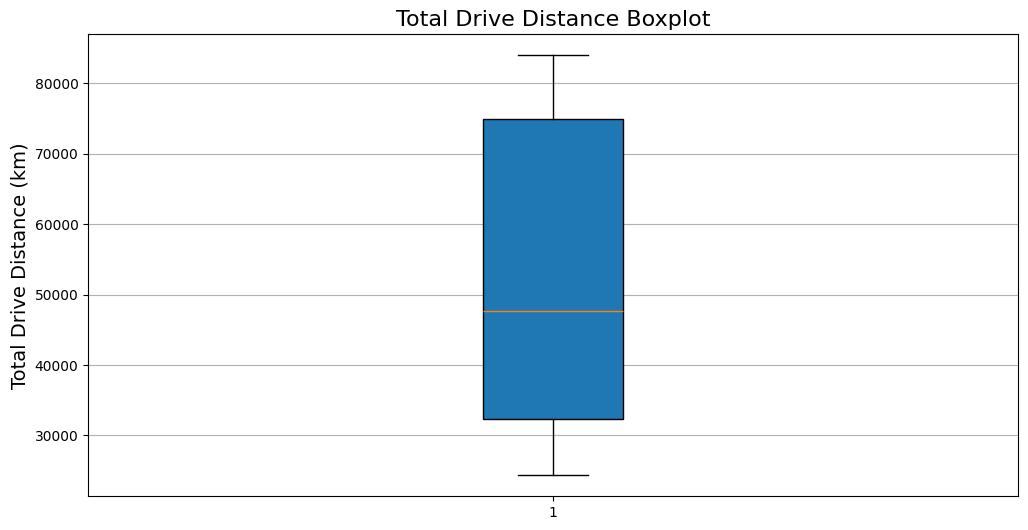

In [80]:
# 박스플롯 그리기
plt.figure(figsize=(12, 6))
plt.boxplot(trip_data, patch_artist=True)


plt.title('Total Drive Distance Boxplot', fontsize=16)
plt.ylabel('Total Drive Distance (km)', fontsize=14)
plt.grid(axis='y')
plt.show()

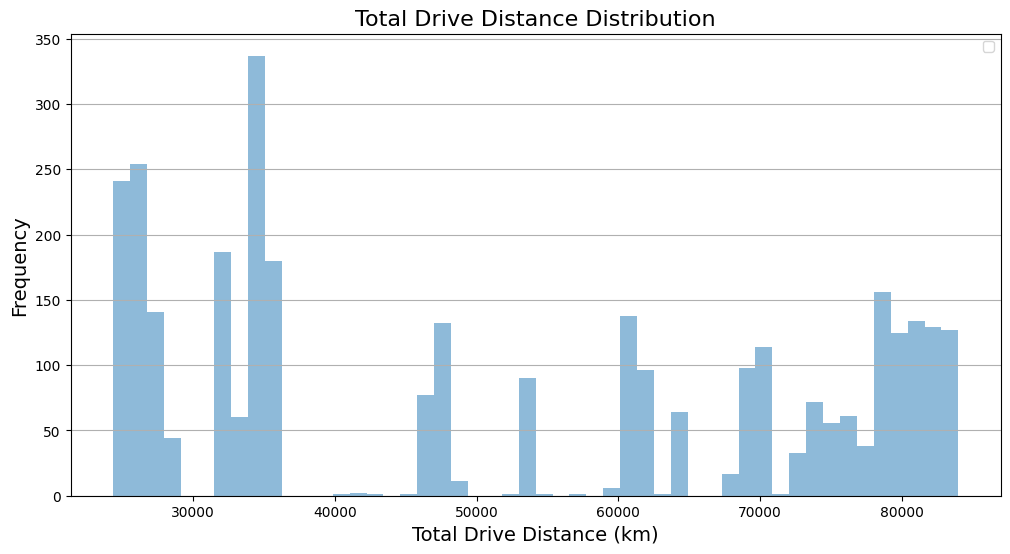

In [77]:
plt.figure(figsize=(12, 6))
plt.hist(trip_data, bins=50, alpha=0.5)

plt.title('Total Drive Distance Distribution', fontsize=16)
plt.xlabel('Total Drive Distance (km)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(axis='y')
plt.show()

In [110]:
trip_id = total_df[(total_df.TripDataCnt > 80) & (total_df.TripDataCnt < 100)].TripID.unique()[10]
single_trip = total_df[total_df.TripID == trip_id]

In [111]:
single_trip.shape

(138, 428)

In [112]:
# 1. CurLatitude와 CurLongitude flatten
latitudes = single_trip[[f'CurLatitude[{i}]' for i in range(6)]].values.flatten()
longitudes = single_trip[[f'CurLongitude[{i}]' for i in range(6)]].values.flatten()

# 2. DataFrame으로 변환
coords_df = pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes})

# 3. NaN 값이 있는 행 제거
coords_df = coords_df.dropna()

# 4. 이상치 제거
Q1_lat = coords_df['Latitude'].quantile(0.25)
Q3_lat = coords_df['Latitude'].quantile(0.75)
IQR_lat = Q3_lat - Q1_lat

Q1_long = coords_df['Longitude'].quantile(0.25)
Q3_long = coords_df['Longitude'].quantile(0.75)
IQR_long = Q3_long - Q1_long

coords_df = coords_df[
    (coords_df['Latitude'] >= (Q1_lat - 1.5 * IQR_lat)) & (coords_df['Latitude'] <= (Q3_lat + 1.5 * IQR_lat)) &
    (coords_df['Longitude'] >= (Q1_long - 1.5 * IQR_long)) & (coords_df['Longitude'] <= (Q3_long + 1.5 * IQR_long))
]

In [113]:
# 5. 지도 시각화
# 기본 지도 생성
m = folium.Map(location=[coords_df['Latitude'].mean(), coords_df['Longitude'].mean()], zoom_start=12)

# 경로를 선으로 연결
folium.PolyLine(locations=coords_df[['Latitude', 'Longitude']].values.tolist(), color='#132257', weight=2.5, opacity=0.8).add_to(m)

# 출발지와 도착지 마커 추가
start_point = coords_df.iloc[0]
end_point = coords_df.iloc[-1]

# 출발지 마커
folium.Marker(
    [start_point['Latitude'], start_point['Longitude']], 
    popup='Start: {0:.4f}, {1:.4f}'.format(start_point['Latitude'], start_point['Longitude']), 
    icon=folium.Icon(color='green', icon='car', prefix='fa')  # 출발지를 구분하는 아이콘
).add_to(m)

# 도착지 마커
folium.Marker(
    [end_point['Latitude'], end_point['Longitude']], 
    popup='End: {0:.4f}, {1:.4f}'.format(end_point['Latitude'], end_point['Longitude']), 
    icon=folium.Icon(color='red', icon='home', prefix='fa')  # 도착지를 구분하는 아이콘
).add_to(m)

# 지도 출력
m.save('map_with_path_and_markers.html')  # HTML 파일로 저장
m  # 주피터 노트북에서 직접 출력할 수 있습니다

## 전처리

In [222]:
df_d = total_df.drop_duplicates('_id')

In [115]:
df_d.shape

(179883, 428)

In [223]:
df_d = df_d[df_d.Type.isin(type_code_list)]

In [224]:
df_d.shape

(178499, 428)

* 타입별로 데이터 분류한 뒤 타입별 필수값 없는 데이터 제거

In [227]:
# 각 Type 값에 해당하는 DataFrame을 딕셔너리에 저장
df_d = {type: df for type, df in df_d.groupby('Type')}

In [121]:
type_code_list

[1, 3, 5, 6, 7, 22, 23, 24]

In [228]:
t_df = df_d[22]

In [229]:
missing_percentage = t_df.isnull().mean() * 100
r_df = missing_percentage.reset_index()
r_df.columns = ['Index', 'Value']
r_df.sort_values(by='Value', ascending=True, inplace=True)

### 1. TripON

In [148]:
r_df[(r_df.Value < 40) & (r_df.Value > 0)]

,Index,Value
408,SOH,0.030741
8,CARCODE,0.491854


In [161]:
drop_columns = r_df[(r_df.Value < 40) & (r_df.Value > 0)].Index.values
d_df = t_df.dropna(subset=drop_columns)

In [147]:
print(t_df.shape[0], d_df.shape[0])

3253 3236


In [150]:
df_d[1] = d_df

### 3. TripData

In [155]:
r_df[(r_df.Value < 5) & (r_df.Value > 0)]

,Index,Value
322,CellMaxMinVol.Single_Pack_Min_Voltage,0.007797
315,SinglePackMaxTemp,0.007797
324,CellMaxMinVolNo.Single_Pack_Max_Voltage_No,0.007797
325,CellMaxMinVolNo.Single_Pack_Min_Voltage_No,0.007797
316,SinglePackMinTemp,0.007797
...,...,...
141,MotorRPM[58],2.181725
142,MotorRPM[59],2.217875
302,PackVoltage[59],2.217875
82,Speed[59],2.217875


In [156]:
drop_columns = r_df[(r_df.Value < 5) & (r_df.Value > 0)].Index.values
d_df = t_df.dropna(subset=drop_columns)

In [157]:
print(t_df.shape[0], d_df.shape[0])

141081 137945


In [158]:
df_d[3] = d_df

### 5. TripOFF

In [165]:
r_df[(r_df.Value < 20) & (r_df.Value > 0)]

,Index,Value
8,CARCODE,0.561798


In [166]:
drop_columns = r_df[(r_df.Value < 20) & (r_df.Value > 0)].Index.values
d_df = t_df.dropna(subset=drop_columns)

In [167]:
print(t_df.shape[0], d_df.shape[0])

3204 3186


In [168]:
df_d[5] = d_df

### 6. KeepGPS

In [176]:
r_df[(r_df.Value < 100) & (r_df.Value > 0)]

,Index,Value
8,CARCODE,0.49416


In [177]:
drop_columns = r_df[(r_df.Value < 20) & (r_df.Value > 0)].Index.values
d_df = t_df.dropna(subset=drop_columns)

In [178]:
print(t_df.shape[0], d_df.shape[0])

4452 4430


In [179]:
df_d[6] = d_df

### 7. KeepAlive

In [182]:
r_df[(r_df.Value < 100) & (r_df.Value > 0)]

,Index,Value
7,FBP,0.022191
5,APP,0.022191
6,OBD2,0.022191
8,CARCODE,0.505947


In [183]:
drop_columns = r_df[(r_df.Value < 20) & (r_df.Value > 0)].Index.values
d_df = t_df.dropna(subset=drop_columns)

In [184]:
print(t_df.shape[0], d_df.shape[0])

22532 22418


In [185]:
df_d[7] = d_df

### 22. ChargeOn

In [230]:
r_df[(r_df.Value < 100) & (r_df.Value > 0)]

,Index,Value


### 23. ChargeData

In [200]:
r_df[(r_df.Value < 100) & (r_df.Value > 0)]

,Index,Value


### 24. ChargeOff

In [207]:
r_df[(r_df.Value < 100) & (r_df.Value > 0)]

,Index,Value


In [192]:
drop_columns = r_df[(r_df.Value < 20) & (r_df.Value > 0)].Index.values
d_df = t_df.dropna(subset=drop_columns)

In [193]:
print(t_df.shape[0], d_df.shape[0])

3751 3737


In [194]:
df_d[24] = d_df

### 24. ChargeOff

In [197]:
r_df[(r_df.Value < 100) & (r_df.Value > 0)]

,Index,Value


### df 합치기

In [210]:
for type_code in type_code_list:
    print(type_code, df_d[type_code].shape[0])

1 3236
3 137945
5 3186
6 4430
7 22418
22 113
23 3737
24 113


In [215]:
df = pd.concat(df_d.values(), ignore_index=True)

In [216]:
df.shape[0]

175178

In [221]:
df.to_pickle('data/1_pmgrow_data.pickle')

## 추가 EDA

In [246]:
import seaborn as sns

In [231]:
df = pd.read_pickle('data/1_pmgrow_data.pickle')

In [240]:
target_columns = [col for col in df.columns if '[' not in col]
target_columns = [col for col in target_columns if df[col].dtype in ['float64', 'int64']]
target_columns = [col for col in target_columns if df[col].isnull().mean() < 0.8]

exclude_columns = [
    'serialnumber', 'Type', 'SubType', 'TripID', 'ModuleTemp_H', 'ModuleTempNo_H', 'ModuleTempNo.SinglePackMaxTempNo', 
    'ModuleTempNo.SinglePackMinTempNo', 'CellMaxMinVol_H', 'CellMaxMinVolNo_H', 'CellMaxMinVolNo.Single_Pack_Max_Voltage_No',
    'CellMaxMinVolNo.Single_Pack_Min_Voltage_No', 'BatteryPackSOH_H'
]
target_columns = [col for col in target_columns if col not in exclude_columns]

In [242]:
corr_matrix = df[target_columns].corr()

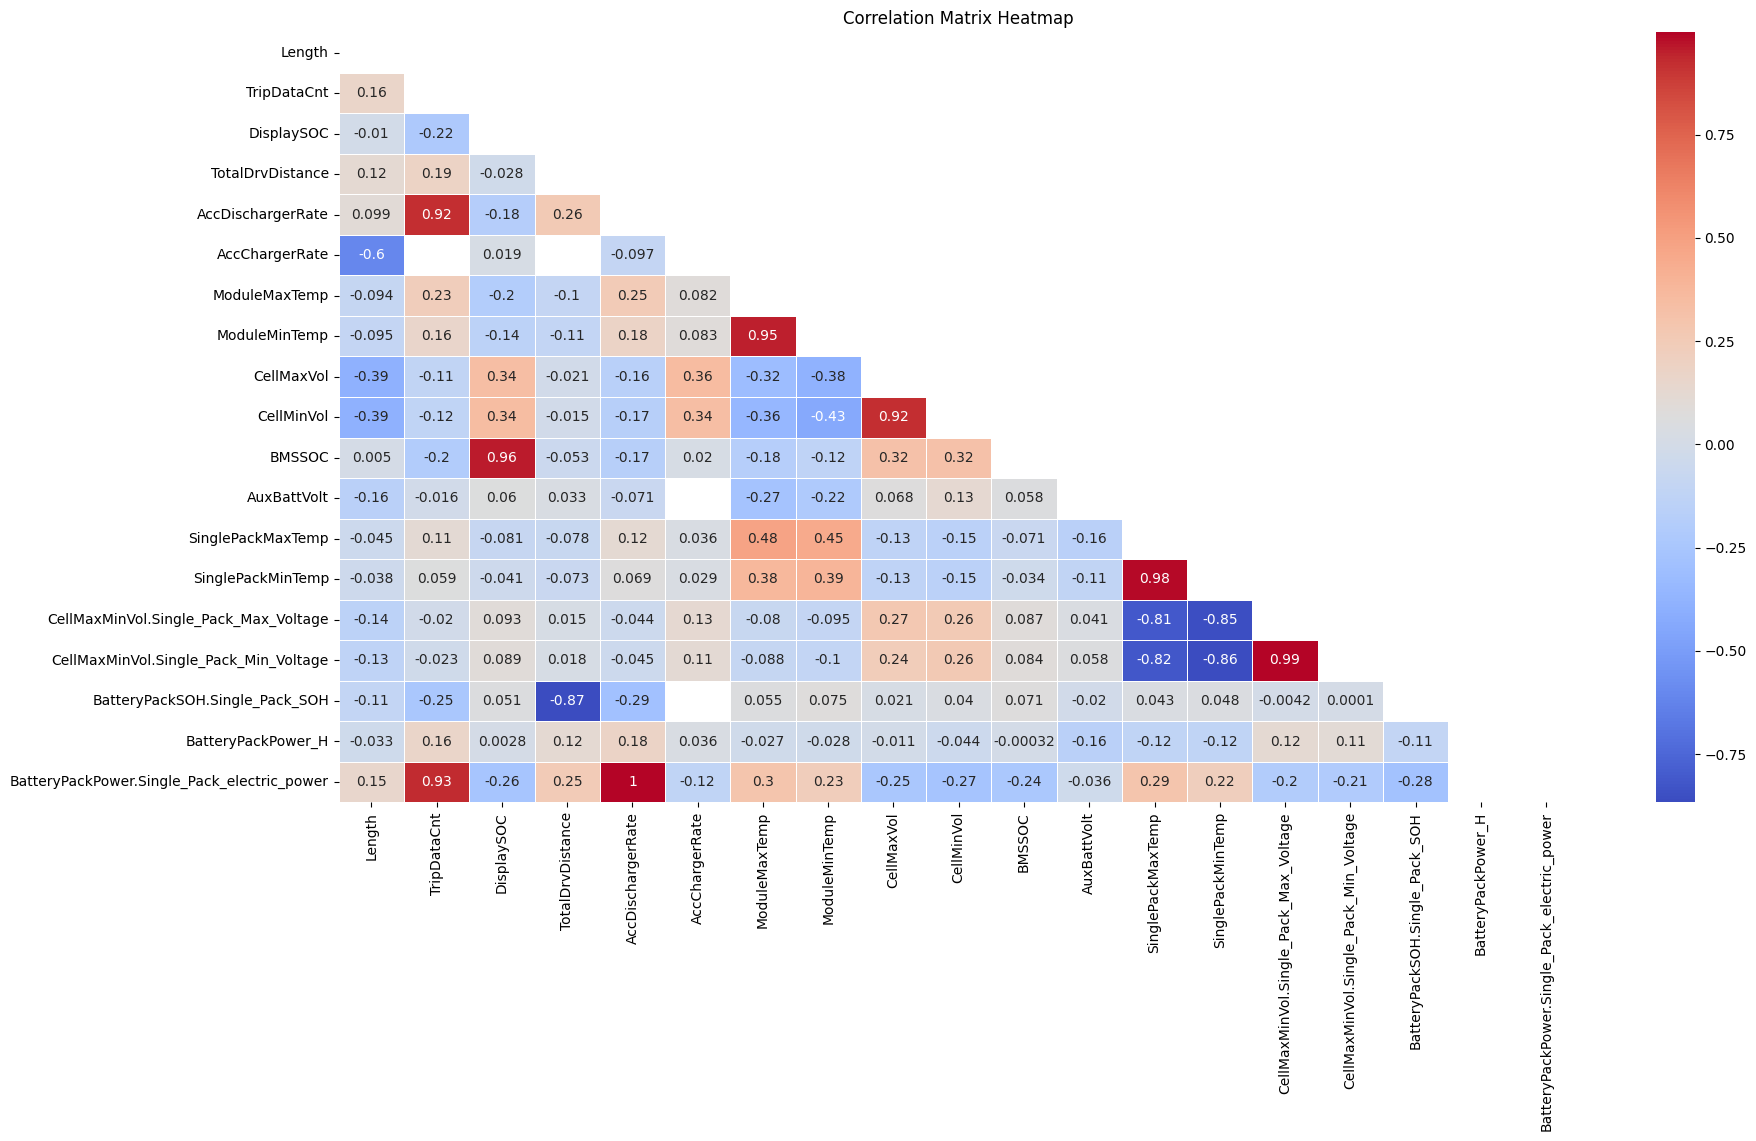

In [247]:
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

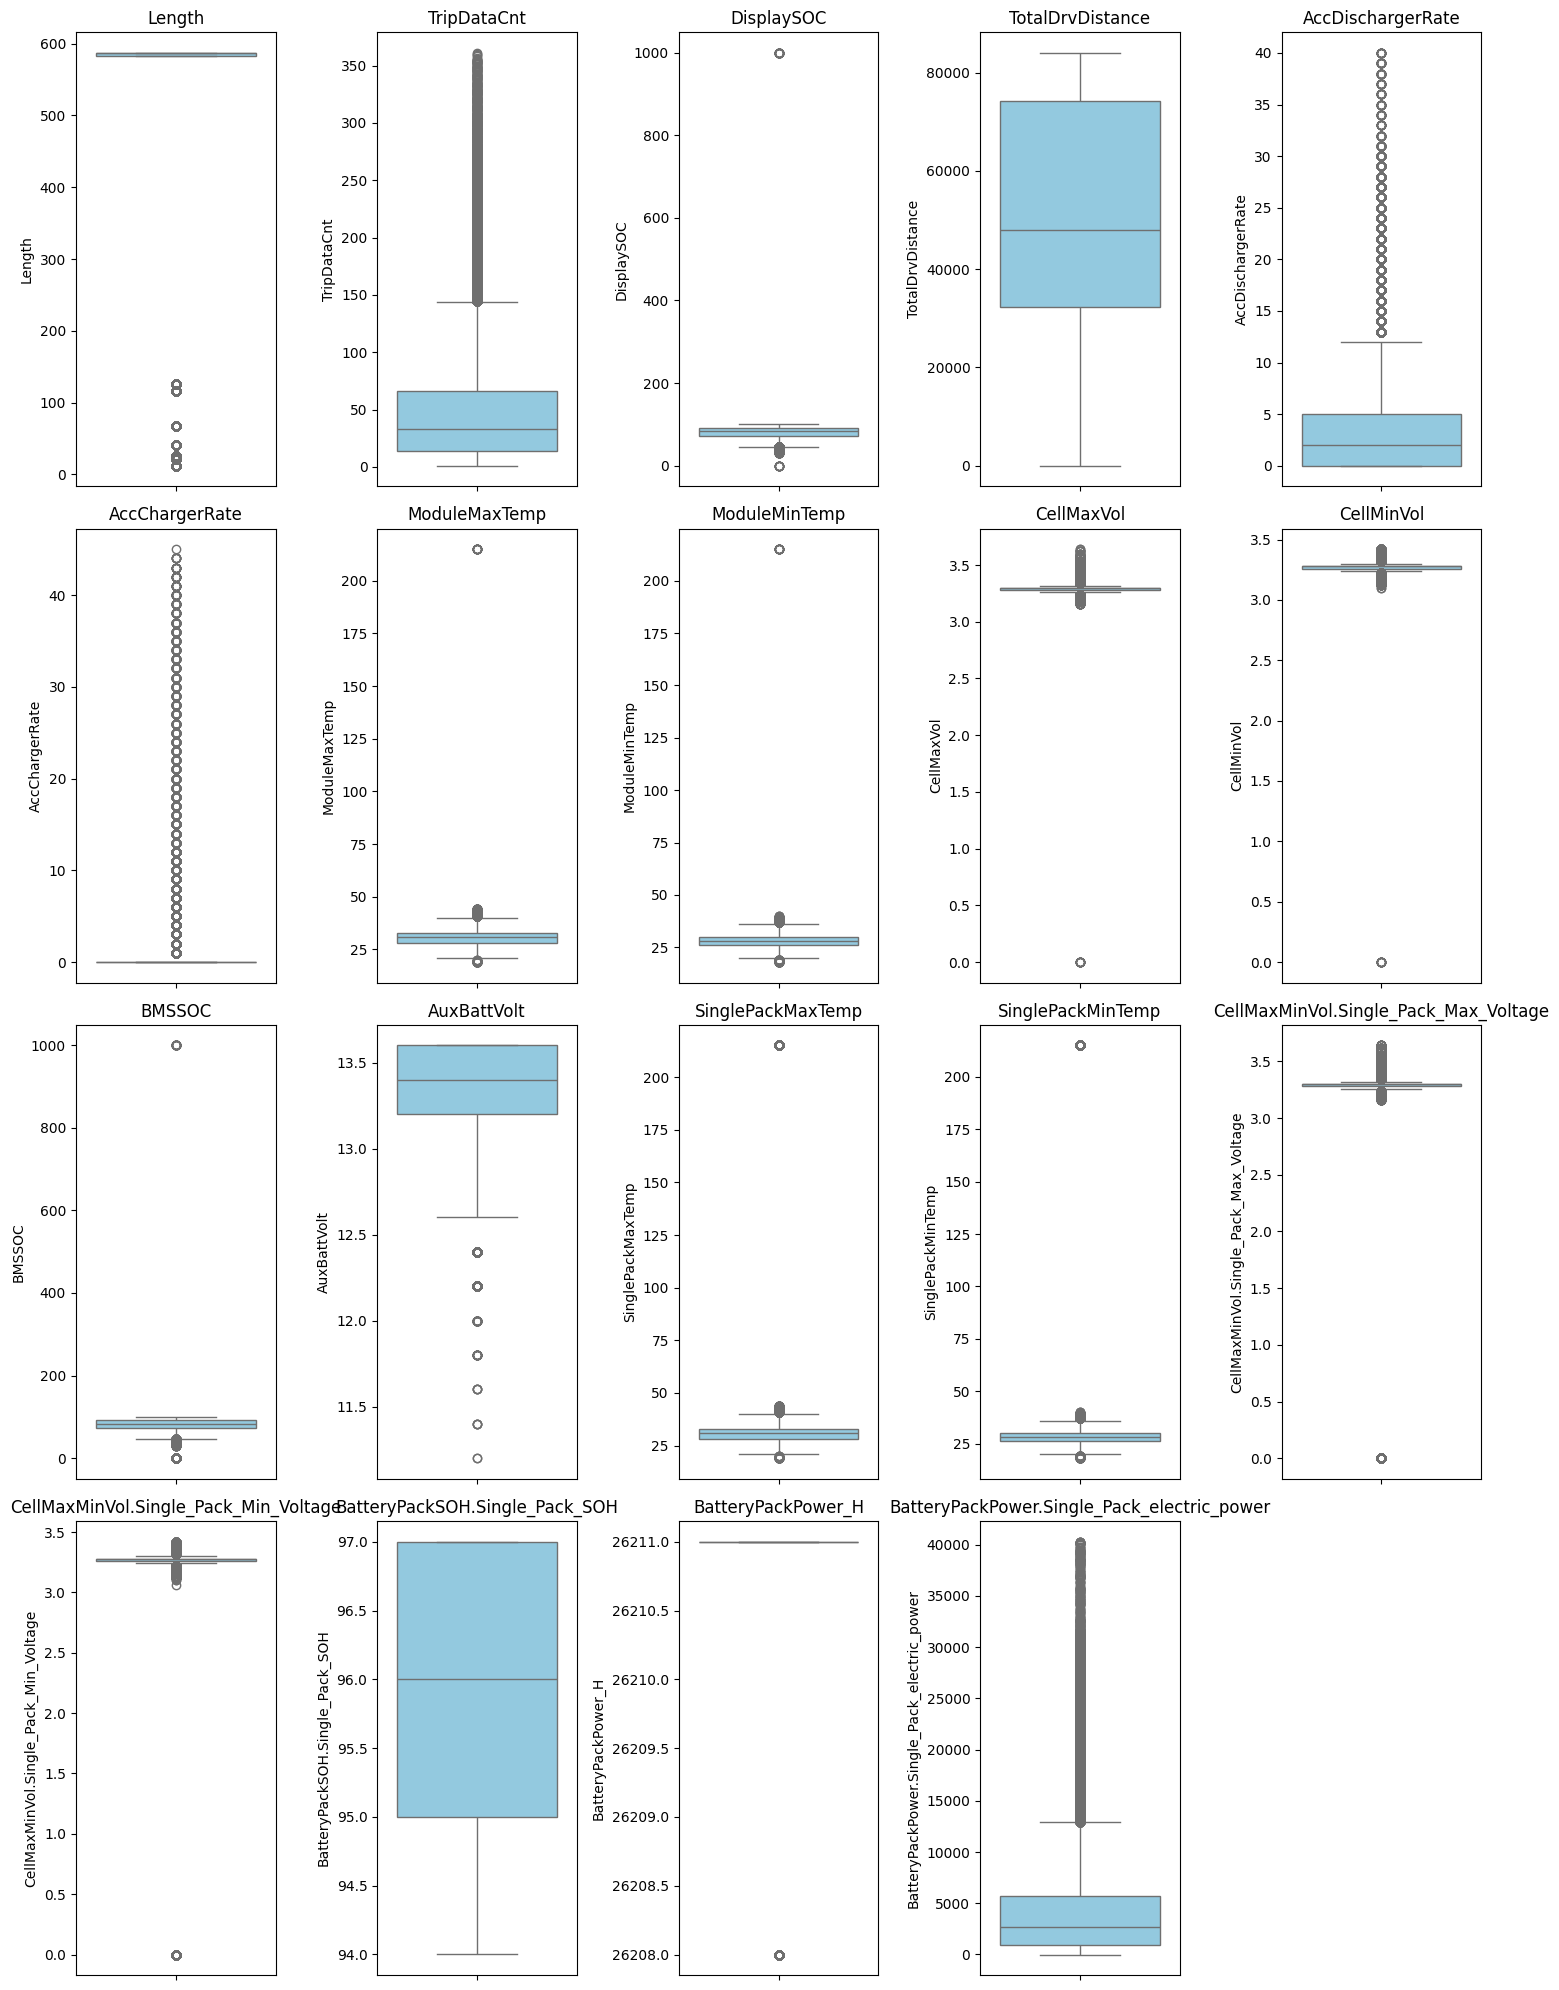

In [250]:
target_df = df[target_columns]

n_cols = 5
n_rows = (len(target_df.columns) + n_cols - 1) // n_cols  # 행의 수 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # 2D 배열을 1D 배열로 변환

for i, col in enumerate(target_columns):
    sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [254]:
df['createdAt'] = pd.to_datetime(df['createdAt'])

In [256]:
df.createdAt.max()

Timestamp('2024-08-14 07:27:14.673000+0000', tz='UTC')

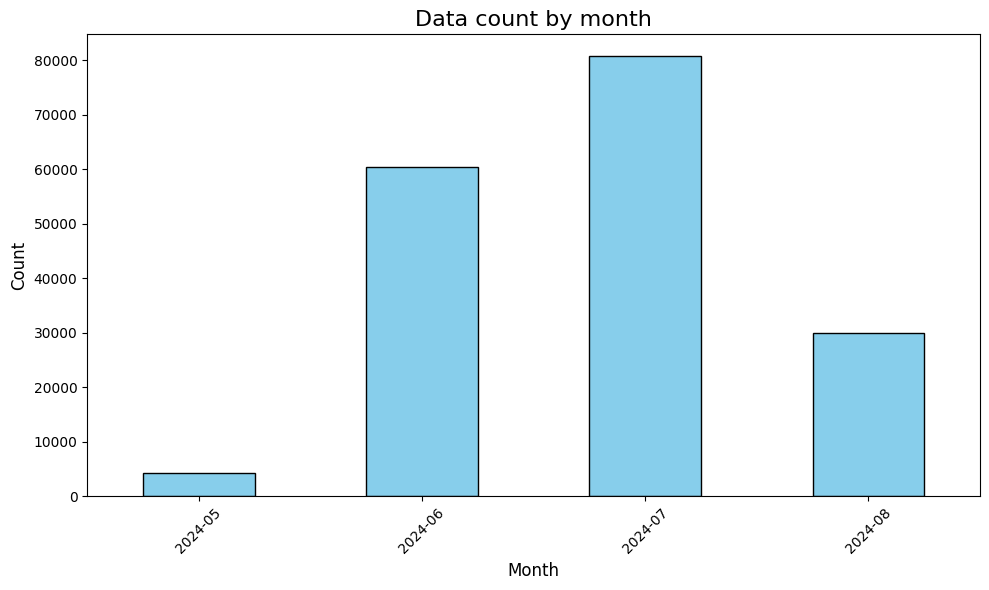

In [260]:
df['YearMonth'] = df['createdAt'].dt.to_period('M')
monthly_data = df.groupby('YearMonth').size()

plt.figure(figsize=(10, 6))
monthly_data.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Data count by month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()